In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from typing import Literal

import string

Resources: 

[1. Text Detection and Removal using OpenCV](https://opencv.org/blog/text-detection-and-removal-using-opencv/)

[2. Recognize text](https://pyimagesearch.com/2018/09/17/opencv-ocr-and-text-recognition-with-tesseract/)

In [144]:
TEMPLATE_SIZE = (50, 40)

def visualize_morphology(img, operation_name, result):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original')

    ax2.imshow(result, cmap='gray')
    ax2.set_title(f'Result after operation - {operation_name}')
    if img.shape == result.shape:
        ax3.imshow(255 - (img - result), cmap='gray',)  # show difference
        ax3.set_title('Difference what changed')
    plt.show()


def segment_license_plate(image: np.ndarray, show: bool = False) -> list[np.ndarray]:
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # gentle erosion
    kernel_erosion = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    eroded = cv2.erode(opening, kernel_erosion)

    # find connected components

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded)

    characters = []
    for i in range (1, num_labels): # skip 0 as background component
        x, y, w, h, area = stats[i]

        # filter by aspect ration 
        aspect_ration = h / w if w > 0 else 0
        should_process = (1.0 < aspect_ration < 3.5) and area > 50
        print(f'ratio: {aspect_ration}, area: {area}, should_process: {should_process}')
        # extract a character from eroded 
        # start at `y` end at `y + h`, for `x`: at `x` end at `x + w`
        char_image  = eroded[y:y+h, x: x+w]

        if should_process: # typical area proportion
            characters.append((x, char_image))  # store position for sorting
            if show:
                plt.imshow(char_image, cmap='gray')
                plt.show()
        
                    
    # sort characters from left to right
    characters.sort(key=lambda arg: arg[0])
    sorted_characters = [char[1] for char in characters]

    return sorted_characters


def recognize_ocr(char_images: list) -> list[str]:
    result = []
    for char_image in char_images:
        text = reader.readtext(char_image, detail=0, allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
        result.append(text[0] if text else '?')
    return result

def preprocess_char_for_ocr(char_img: np.ndarray, show: bool = False) -> np.ndarray:
    """Prepare character image for Tesseract recognition."""
    # 1. Ensure correct dtype
    if char_img.dtype != np.uint8:
        char_img = char_img.astype(np.uint8)
    
    # 2. Ensure white text on black background (Tesseract prefers dark-on-light)
    # Check if image is inverted (more white than black = likely inverted)
    if np.mean(char_img) > 127:
        char_img = 255 - char_img  # Invert
    
    # 3. Add padding (Tesseract struggles with chars touching edges)
    pad = 20
    padded = cv2.copyMakeBorder(
        char_img, pad, pad, pad, pad,
        cv2.BORDER_CONSTANT, value=0
    )
    
    # 4. Resize to reasonable size (Tesseract likes ~30-50px height)
    height = padded.shape[0]
    if height < 30:
        scale = 50 / height
        padded = cv2.resize(padded, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    
    # 5. Invert back: Tesseract expects black text on white background
    final = 255 - padded

    # 6. erode to accent the shape
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    transformed = cv2.erode(final, kernel, iterations=1)
    if show:
        visualize_morphology(
            img=final,
            operation_name='dilate',
            result=transformed
        )
    
    return transformed


def recognize_plate_characters(char_images: list, config: str | None = None, show: bool = False) -> str:
    """Convert list of character images to string."""
    # Tesseract config for single characters
    config  = config or (
        '--psm 10 '           # PSM 10 = single character mode
        '--oem 3 '            # Use LSTM + legacy engine
        '-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    )
    
    result = []
    for char_img in char_images:
        processed = preprocess_char_for_ocr(char_img, show=show)
        text = pytesseract.image_to_string(processed, config=config).strip()
        result.append(text if text else '?')  # Mark unrecognized chars
    
    return ''.join(result)


TEMPLATE_SIZE = (50, 40)

# another method for education
def create_char_templates() -> dict:
    templates = {}
    chars = string.ascii_uppercase + string.digits

    for char in chars:
        template = np.zeros(TEMPLATE_SIZE, dtype=np.uint8)
        # template = np.zeros((50, 40), dtype=np.uint8)
        cv2.putText(template, char, (5, 40), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=266, thickness=2)
        templates[char] = 255 - template
    return templates



def extract_structural_features(char_img: np.ndarray) -> dict:
    """Extract structural features from character image."""
    h, w = char_img.shape

    # Normalize
    if char_img.max() > 0:
        normalized = (char_img > char_img.max() * 0.5).astype(np.uint8) * 255
    else:
        normalized = char_img

    total = max(normalized.sum(), 1)

    # Horizontal profile (top, mid, bottom)
    top_third = normalized[:h//3, :].sum() / total
    mid_third = normalized[h//3:2*h//3, :].sum() / total
    bot_third = normalized[2*h//3:, :].sum() / total

    # Top bar detection
    top_region = normalized[:h//5, :]
    top_density = top_region.sum() / max(normalized[:h//2, :].sum(), 1)
    has_top_bar = top_density > 0.25

    # Width at different heights
    top_width = np.count_nonzero(normalized[h//6, :])
    mid_width = np.count_nonzero(normalized[h//2, :])

    return {
        'h_profile': (top_third, mid_third, bot_third),
        'has_top_bar': has_top_bar,
        'top_width': top_width,
        'mid_width': mid_width,
    }

def match_character_with_features(
    char_img: np.ndarray, 
    templates: dict,
    template_features: dict
) -> str:
    """Hybrid matching: template correlation + structural features."""
    char_resized = cv2.resize(char_img, (45, 60))
    char_features = extract_structural_features(char_resized)
    
    best_match = '?'
    best_score = -1
    
    for char, template in templates.items():
        # Template matching score
        result = cv2.matchTemplate(char_resized, template, cv2.TM_CCOEFF_NORMED)
        template_score = result.max()
        
        # Structural feature similarity
        tmpl_feat = template_features[char]
        
        # Compare horizontal profiles
        h_diff = sum(abs(a - b) for a, b in zip(char_features['h_profile'], tmpl_feat['h_profile']))
        
        # Penalize if top_bar mismatch (critical for T vs 1)
        top_bar_penalty = 0.3 if char_features['has_top_bar'] != tmpl_feat['has_top_bar'] else 0
        
        # Combined score
        feature_score = 1 - h_diff - top_bar_penalty
        combined_score = 0.6 * template_score + 0.4 * feature_score
        
        if combined_score > best_score:
            best_score = combined_score
            best_match = char
    
    return best_match if best_score > 0.4 else '?'



def match_character_naive(char_img: np.ndarray, templates: dict) -> str:
    # resize image to template size
    resized = cv2.resize(char_img, (TEMPLATE_SIZE[1], TEMPLATE_SIZE[0]) )

    best_match, best_score = '?', -1

    for char, template in templates.items():
        # normalized cross correlation
        result = cv2.matchTemplate(resized, template, cv2.TM_CCOEFF_NORMED)
        score = result.max()
        visualize_morphology(resized, f'score: {score/ 10**7}', template)
        if score > best_score:
            best_score = score
            best_match = char

    print(f'Best score: {best_score}')
    return best_match if best_score > 0.5 else '?'
    

In [13]:
string.digits

'0123456789'

In [92]:
img = cv2.imread('/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/ru_plate.jpg', cv2.IMREAD_GRAYSCALE)

result = segment_license_plate(img)
'T056EX750'

ratio: 0.11, area: 33380, should_process: False
ratio: 0.43166666666666664, area: 92238, should_process: False
ratio: 0.5, area: 18, should_process: False
ratio: 1.6285714285714286, area: 621, should_process: True
ratio: 1.5405405405405406, area: 865, should_process: True
ratio: 1.4473684210526316, area: 924, should_process: True
ratio: 1.5869565217391304, area: 1383, should_process: True
ratio: 1.5416666666666667, area: 1289, should_process: True
ratio: 1.574468085106383, area: 1319, should_process: True
ratio: 1.4473684210526316, area: 551, should_process: True
ratio: 1.2954545454545454, area: 1010, should_process: True
ratio: 1.3333333333333333, area: 826, should_process: True
ratio: 0.5714285714285714, area: 85, should_process: False
ratio: 0.6, area: 110, should_process: False
ratio: 0.08888888888888889, area: 161, should_process: False


'T056EX750'

In [93]:
len(result)

9

In [128]:
chars = [pytesseract.image_to_string(char) for char in result]
print(chars)

['', '', '', '', '', '', '', '', '']


In [127]:
recognize_plate_characters(result)

'TQ56EX7FSO'

In [ ]:
pre_processsed = [preprocess_char_for_ocr(char) for char in result]

# for i in range(len(result)):
#     visualize_morphology(
#         img=result[i],
#         operation_name='padding',
#         result=pre_processsed[i]
#     )

In [71]:
templates = create_char_templates()
template_features = {
    char: extract_structural_features(char_img) for char, char_img in templates.items()
}
match_character_with_features(pre_processsed[1], templates, template_features) 
# visualize_morphology(templates['x'], 'test', templates['x'])
# visualize_morphology(templates['X'], 'test', templates['X'])
# visualize_morphology(templates['W'], 'test', templates['X'])
# visualize_morphology(templates['1'], 'test', templates['X'])

'0'

In [ ]:
# config = ("-l eng --oem 1 --psm 4")
config = '--psm 10 --oem 1 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPRSTVUQWXYZ0123456789'
print(pytesseract.image_to_string(pre_processsed[1], config=config))

0



In [73]:
expected = 'T056EX750'

''.join([pytesseract.image_to_string(im, config=config) for im in pre_processsed]).replace('\n', '')

'T056EX750'

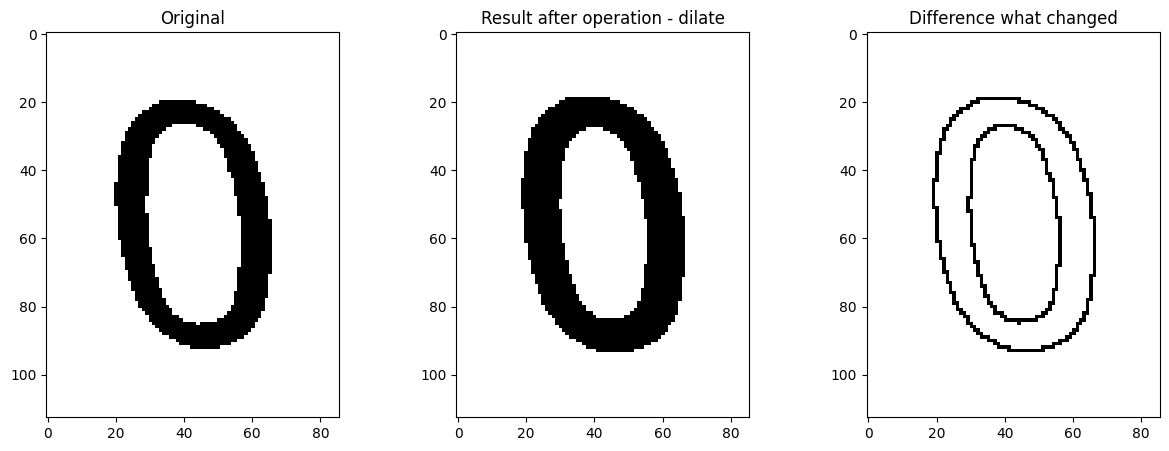

0



In [ ]:
# transform the image a bit:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
dilated = cv2.erode(pre_processsed[1], kernel, iterations=1)

visualize_morphology(pre_processsed[1], 'dilate', dilated)

print(pytesseract.image_to_string(dilated, config=config))

In [76]:
print(pytesseract.image_to_string(dilated, config=config))

0



ratio: 0.08310991957104558, area: 52953, should_process: False
ratio: 0.96, area: 444, should_process: False
ratio: 0.6304347826086957, area: 1100, should_process: False
ratio: 0.92, area: 433, should_process: False
ratio: 0.6666666666666666, area: 23, should_process: False
ratio: 0.3333333333333333, area: 27, should_process: False
ratio: 0.4, area: 184, should_process: False
ratio: 0.4166666666666667, area: 183, should_process: False
ratio: 0.4117647058823529, area: 103, should_process: False
ratio: 0.3531468531468531, area: 234465, should_process: False
ratio: 0.5, area: 18, should_process: False
ratio: 1.5454545454545454, area: 3062, should_process: True
ratio: 1.5538461538461539, area: 3024, should_process: True
ratio: 1.528735632183908, area: 5156, should_process: True
ratio: 1.5714285714285714, area: 5026, should_process: True
ratio: 1.5057471264367817, area: 4780, should_process: True
ratio: 9.428571428571429, area: 724, should_process: False
ratio: 1.1111111111111112, area: 382

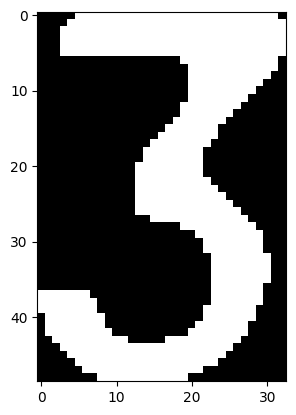

ratio: 1.53125, area: 675, should_process: True


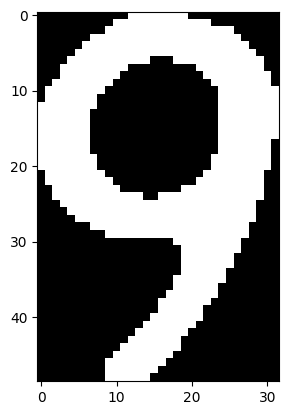

ratio: 1.5116279069767442, area: 1096, should_process: True


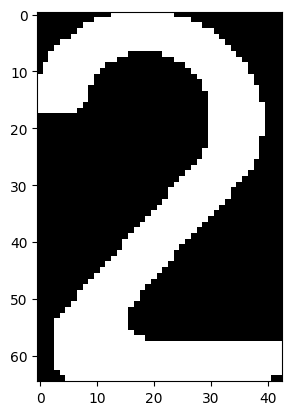

ratio: 1.4772727272727273, area: 1195, should_process: True


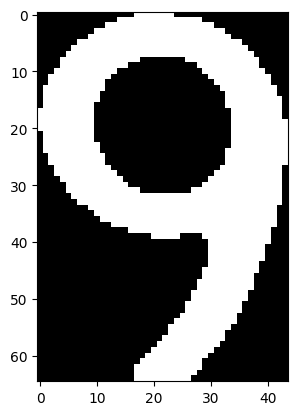

ratio: 1.5476190476190477, area: 1150, should_process: True


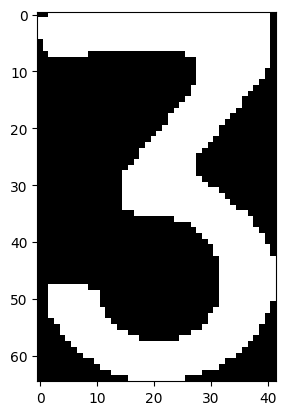

ratio: 1.1162790697674418, area: 771, should_process: True


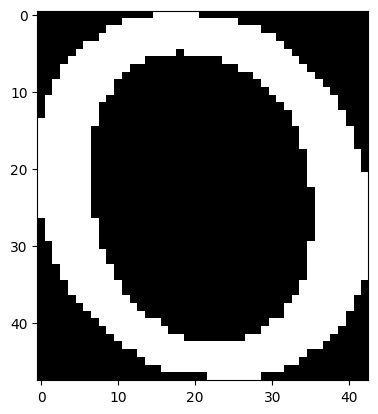

ratio: 1.0888888888888888, area: 892, should_process: True


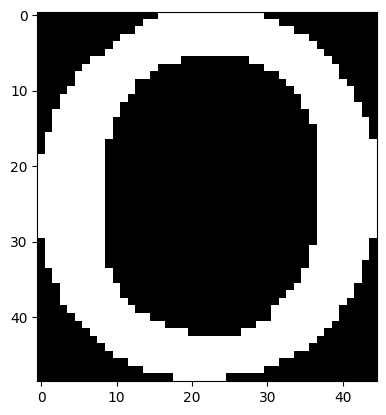

ratio: 1.2, area: 881, should_process: True


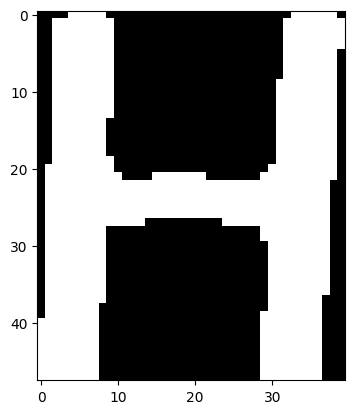

ratio: 0.23076923076923078, area: 111, should_process: False
ratio: 0.6, area: 15, should_process: False
ratio: 1.0, area: 45, should_process: False
ratio: 0.6666666666666666, area: 24, should_process: False
ratio: 1.2, area: 30, should_process: False
ratio: 0.6, area: 15, should_process: False
ratio: 1.0, area: 25, should_process: False
ratio: 1.125, area: 50, should_process: False
ratio: 0.8, area: 20, should_process: False
ratio: 0.7, area: 55, should_process: False
ratio: 0.6, area: 15, should_process: False
ratio: 0.04195804195804196, area: 7596, should_process: False


(10, 8)

In [ ]:
# another plate

img2 = cv2.imread('/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/ru_plate_2.png', cv2.IMREAD_GRAYSCALE)

# let's 
img2_resized = cv2.resize(img2, (img2.shape[1]//2, img2.shape[0]//2))
result2 = segment_license_plate(img2,)
result2_resized = segment_license_plate(img2_resized, show=True)

len(result2), len(result2_resized)

In [ ]:
recognize_plate_characters(result2_resized)

In [125]:
recognize_plate_characters(result2_resized)

'O293OH39'

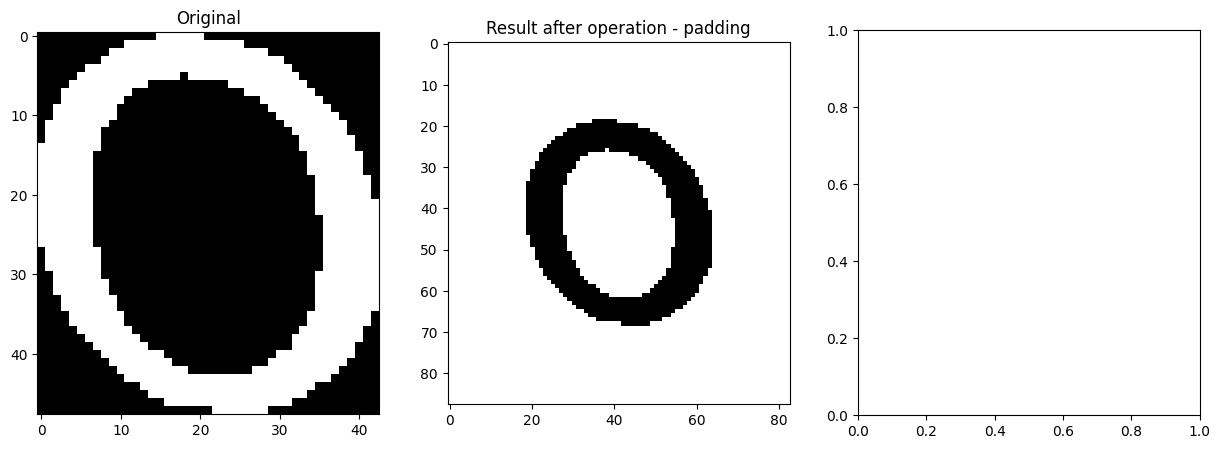

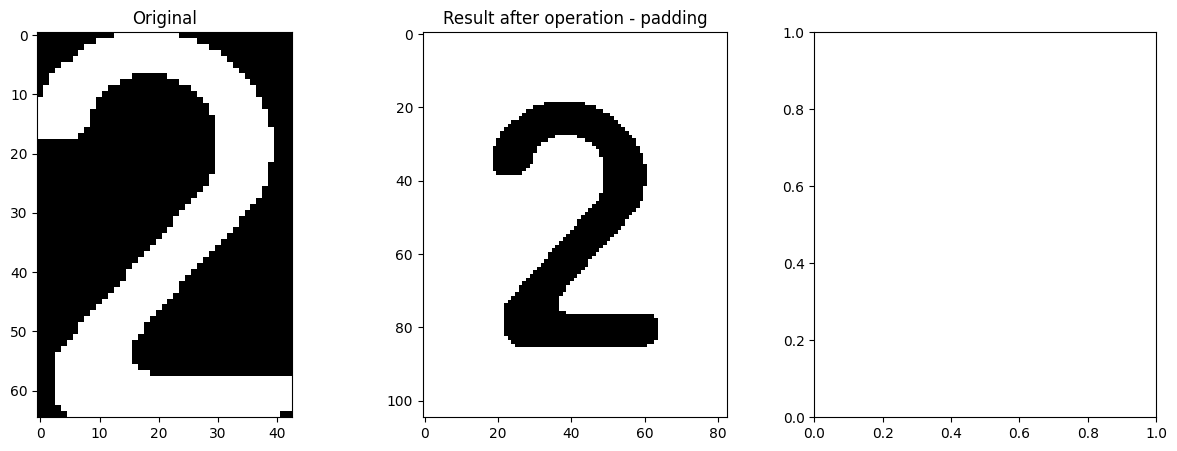

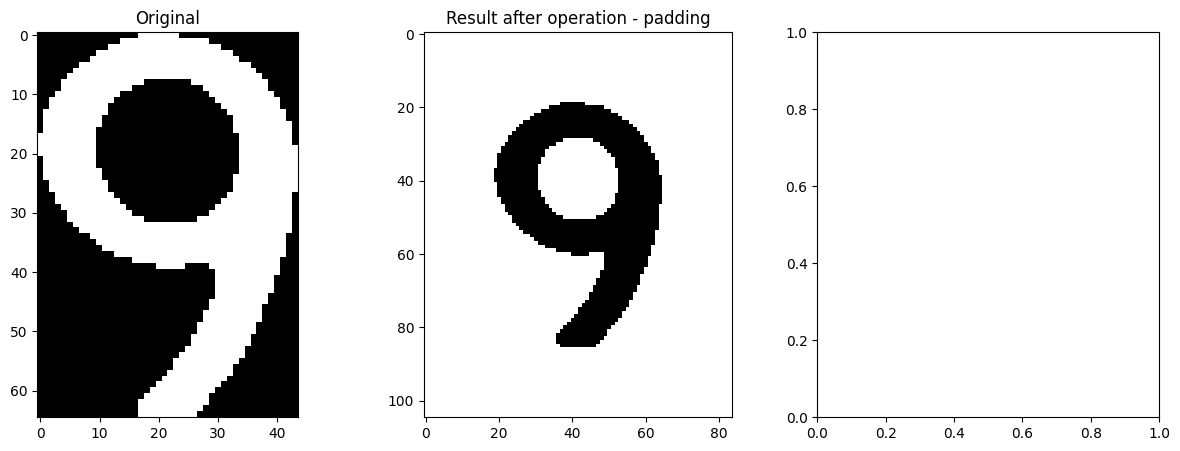

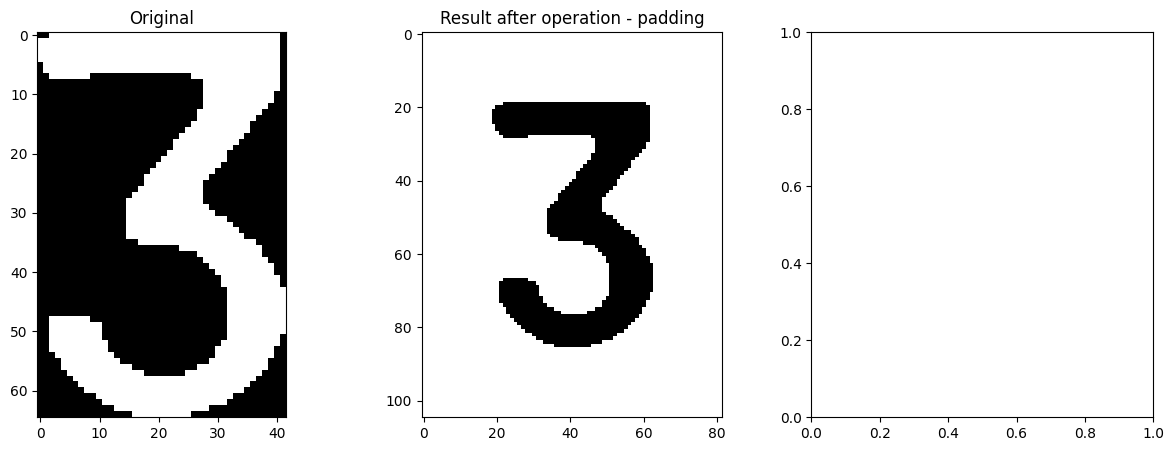

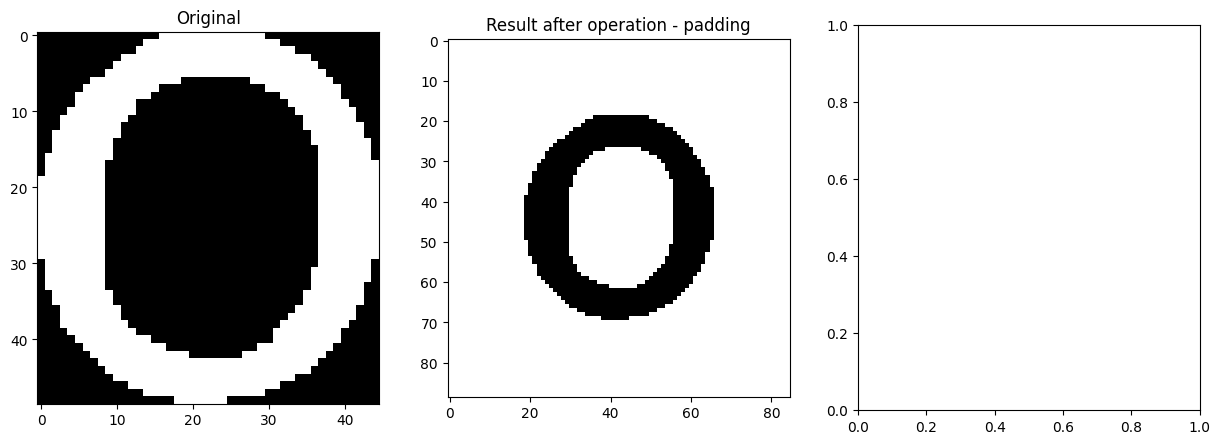

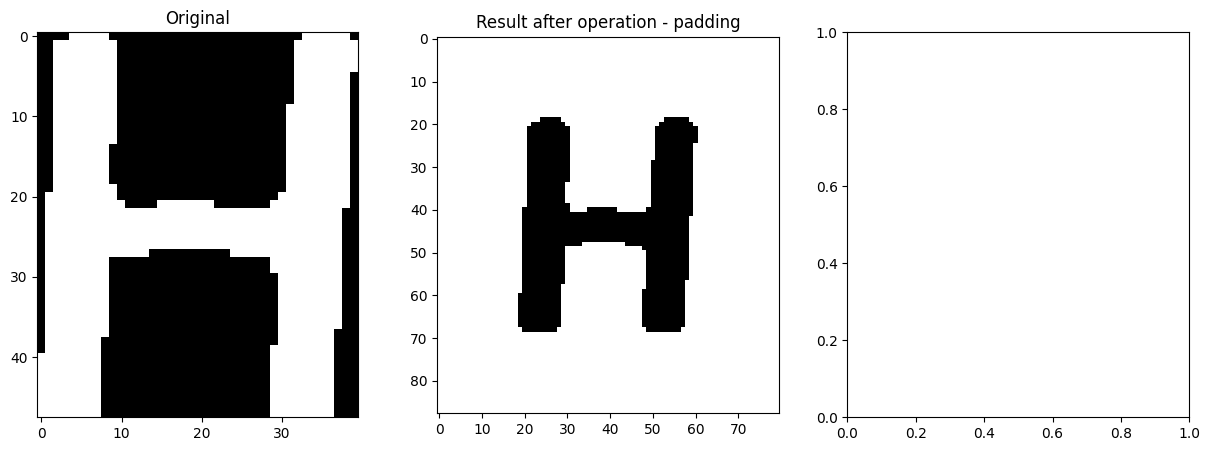

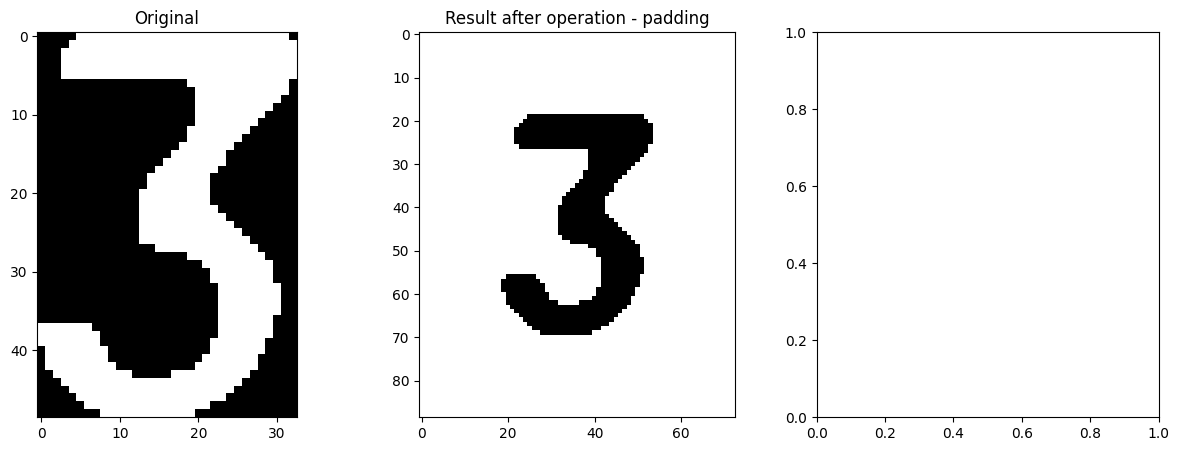

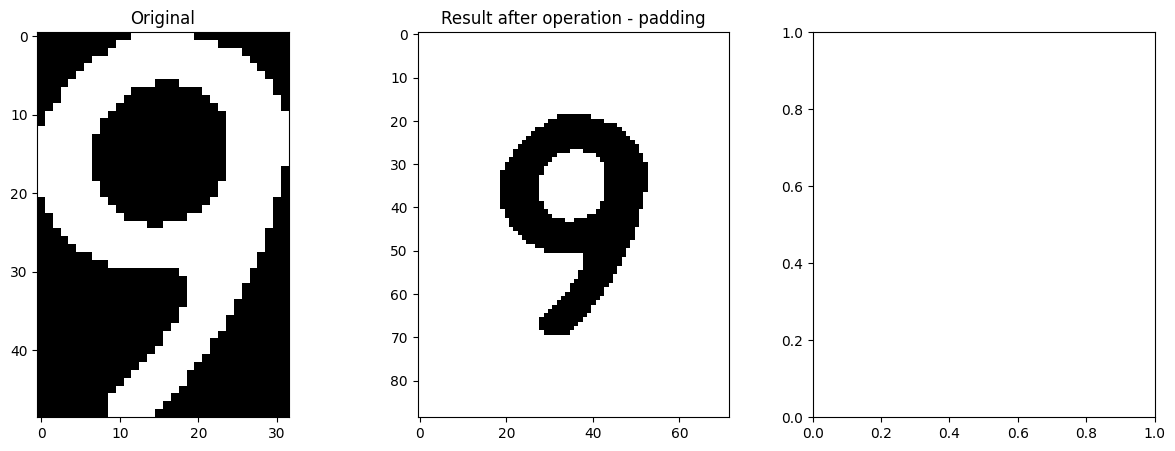

In [109]:
pre_processsed2 = [preprocess_char_for_ocr(char) for char in result2_resized]

for i in range(len(result2_resized)):
    visualize_morphology(
        img=result2_resized[i],
        operation_name='padding',
        result=pre_processsed2[i]
    )

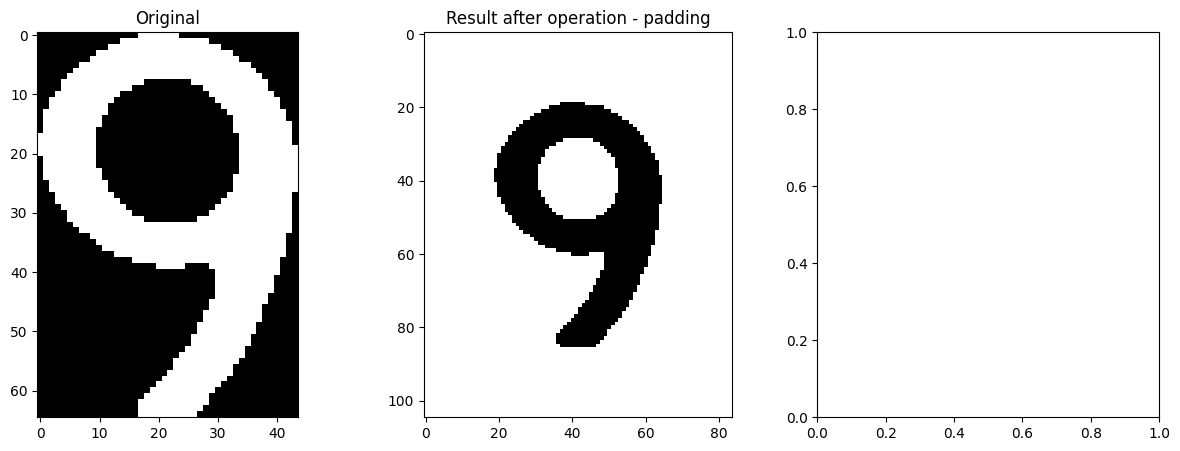

In [112]:
visualize_morphology(
        img=result2_resized[2],
        operation_name='padding',
        result=pre_processsed2[2]
    )

In [147]:
# config = ("-l eng --oem 1 --psm 4")
config = '--psm 10 --oem 1 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPRSTVUQWXYZ0123456789'
# pytesseract.image_to_string(pre_processsed2[2], config=config)
candidate = result2_resized[2]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

dilated = cv2.dilate(candidate, kernel)

recognize_plate_characters([dilated], config=config)


'9'

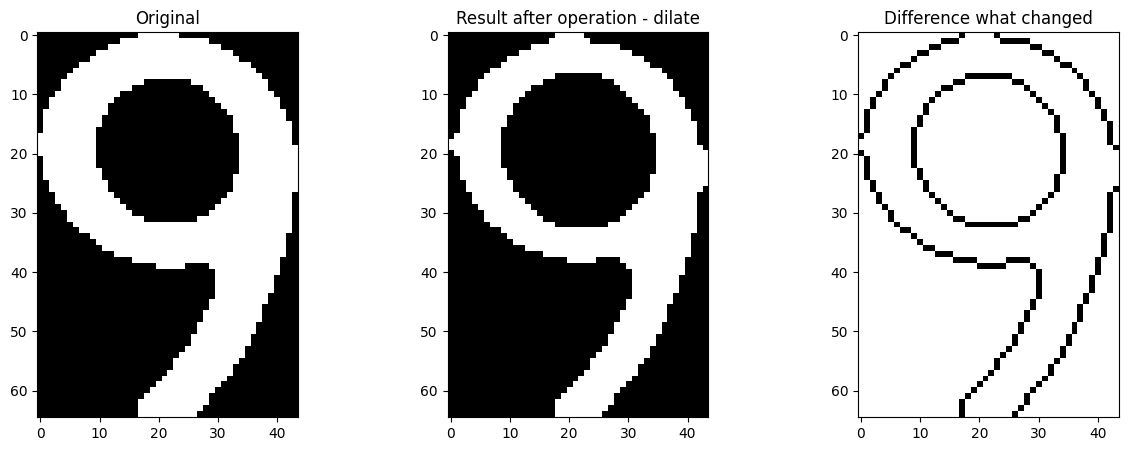

In [121]:
visualize_morphology(
        img=candidate,
        operation_name='dilate',
        result=dilated
    )

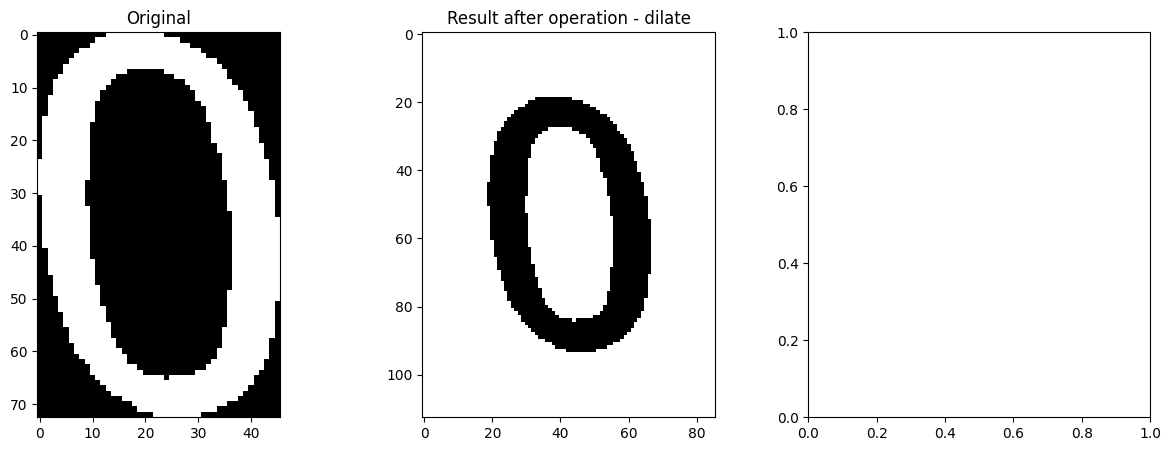

'0'

In [135]:
candidate1 = result[1]

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

# transformed = cv2.dilate(candidate1, kernel)

transformed  = preprocess_char_for_ocr(candidate1)


visualize_morphology(
        img=candidate1,
        operation_name='dilate',
        result=transformed
    )
recognize_plate_characters([transformed], config=config)

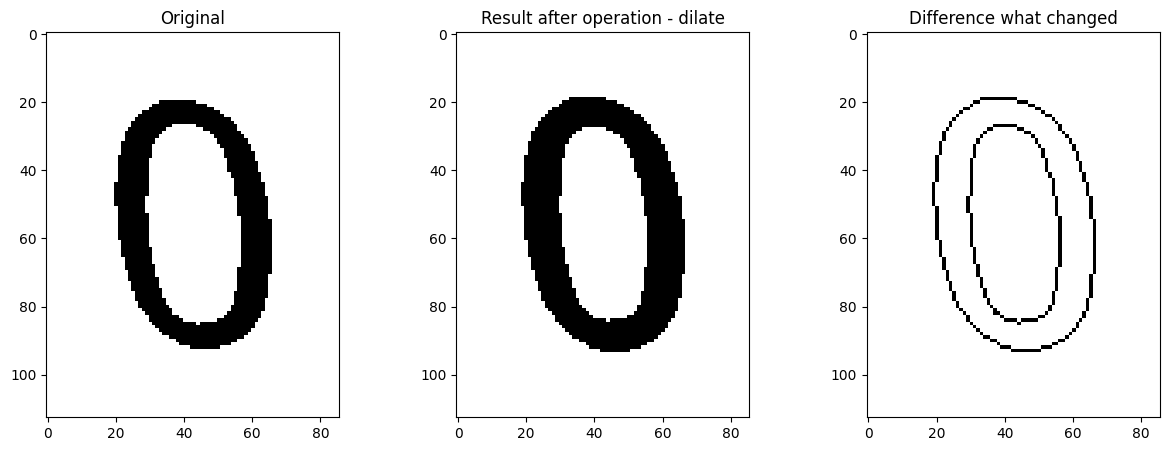

0


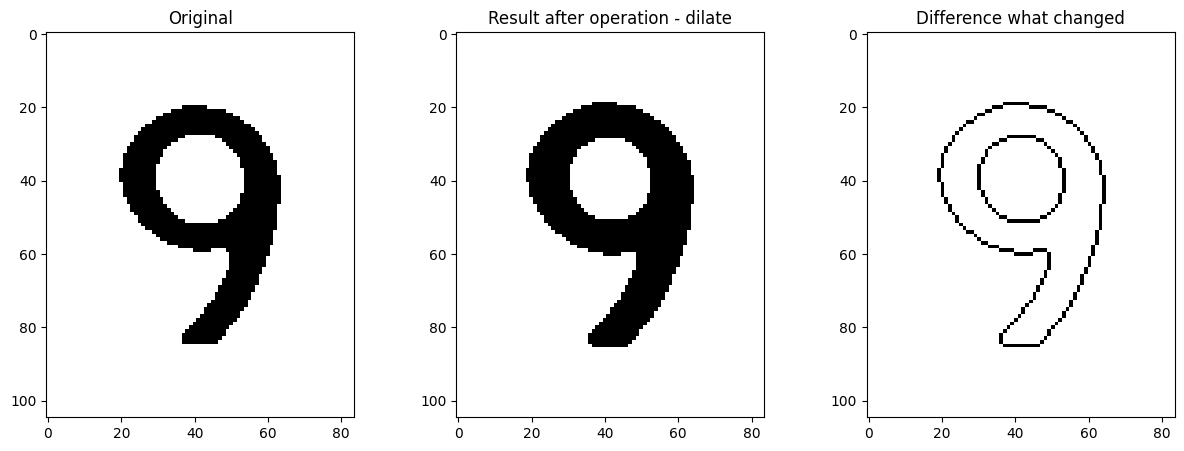

?


In [148]:
candidate1 = result[1]

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

# transformed = cv2.dilate(candidate1, kernel)

# transformed  = preprocess_char_for_ocr(candidate1)


# visualize_morphology(
#         img=candidate1,
#         operation_name='dilate',
#         result=transformed
#     )
print(recognize_plate_characters([candidate1], show=True))
print(recognize_plate_characters([candidate], show=True))


In [149]:
type(candidate1)

numpy.ndarray

In [155]:
_, counts = np.unique(candidate1, return_counts=True)
counts, counts[1]/counts[0]

(array([1975, 1383]), np.float64(0.7002531645569621))

In [156]:
_, counts = np.unique(candidate, return_counts=True)
counts, counts[1]/counts[0]


(array([1665, 1195]), np.float64(0.7177177177177178))